In [1]:
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD

import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU

Using TensorFlow backend.


In [7]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 5000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

# Load the data

In [3]:
input_texts = []
target_texts = []
for line in open('./data/robert_frost.txt'):
    line = line.rstrip()
    if not line:
        continue

    input_line = '<sos> ' + line
    target_line = line + ' <eos>'

    input_texts.append(input_line)
    target_texts.append(target_line)

all_lines = input_texts + target_texts

len(all_lines)

2872

In [5]:
input_texts[:5]

['<SOS> Two roads diverged in a yellow wood,',
 '<SOS> And sorry I could not travel both',
 '<SOS> And be one traveler, long I stood',
 '<SOS> And looked down one as far as I could',
 '<SOS> To where it bent in the undergrowth;']

In [6]:
target_texts[:5]

['Two roads diverged in a yellow wood, <EOS>',
 'And sorry I could not travel both <EOS>',
 'And be one traveler, long I stood <EOS>',
 'And looked down one as far as I could <EOS>',
 'To where it bent in the undergrowth; <EOS>']

# Convert text with Tokenizer to corpus and sequences

In [8]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

In [9]:
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length:', max_sequence_length_from_data)

Max sequence length: 12


In [10]:
word2idx = tokenizer.word_index

In [11]:
len(word2idx)

3056

In [13]:
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

### Pad sequences (N x T matrix)

In [14]:
max_sequence_length = min(max_sequence_length_from_data, MAX_SEQUENCE_LENGTH)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')

In [15]:
print('Shape of data tensor:', input_sequences.shape)

Shape of data tensor: (1436, 12)


# Loading word vectors

In [16]:
word2vec = {}
with open(os.path.join('./data/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    # is just a space-separated text file in the format:
    # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec


In [17]:
len(word2vec)

400000

# Prepare embeding matrix

In [18]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1) # +1 because word2idx starts from 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

In [19]:
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

### Create embedding layer

In [20]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  # trainable=False
)

# One-Hot-Encoding for targets

### We can't use sparse cross-entropy, because each target is a sequence. We have T targets per 1 input.

In [21]:
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
    for t, word in enumerate(target_sequence):
        if word > 0:
            one_hot_targets[i, t, word] = 1


In [23]:
one_hot_targets.shape

(1436, 12, 3057)

In [25]:
one_hot_targets[:2]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

# Building our model

### LSTM network with single LSTM

In [26]:
input_ = Input(shape=(max_sequence_length,))
initial_h = Input(shape=(LATENT_DIM,))
initial_c = Input(shape=(LATENT_DIM,))
x = embedding_layer(input_)

Instructions for updating:
Colocations handled automatically by placer.


In [27]:
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c]) # don't need the states here
dense = Dense(num_words, activation='softmax')
output = dense(x)

In [28]:
model = Model([input_, initial_h, initial_c], output)
model.compile(
  loss='categorical_crossentropy',
  # optimizer='rmsprop',
  optimizer=Adam(lr=0.01),
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)

# Training the model

In [29]:
# initial state just 0's
z = np.zeros((len(input_sequences), LATENT_DIM))

In [30]:
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1148 samples, validate on 288 samples
Epoch 1/2000
1148/1148 [==============================] - 3s 3ms/step - loss: 5.4109 - acc: 0.0666 - val_loss: 5.2122 - val_acc: 0.0833
Epoch 2/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 4.6289 - acc: 0.0833 - val_loss: 5.0143 - val_acc: 0.0836
Epoch 3/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 4.3731 - acc: 0.0833 - val_loss: 5.1215 - val_acc: 0.0833
Epoch 4/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 4.3127 - acc: 0.0833 - val_loss: 5.1666 - val_acc: 0.0833
Epoch 5/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 4.2632 - acc: 0.0833 - val_loss: 5.2150 - val_acc: 0.0833
Epoch 6/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 4.2431 - acc: 0.0833 - val_loss: 5.2316 - val_acc: 0.0833
Epoch 7/200

1148/1148 [==============================] - 2s 2ms/step - loss: 2.7994 - acc: 0.1973 - val_loss: 5.4100 - val_acc: 0.0955
Epoch 57/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 2.7772 - acc: 0.1990 - val_loss: 5.4190 - val_acc: 0.0964
Epoch 58/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 2.7567 - acc: 0.2027 - val_loss: 5.4202 - val_acc: 0.0958
Epoch 59/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 2.7398 - acc: 0.2046 - val_loss: 5.4385 - val_acc: 0.0964
Epoch 60/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 2.7174 - acc: 0.2059 - val_loss: 5.4422 - val_acc: 0.0955
Epoch 61/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 2.6982 - acc: 0.2079 - val_loss: 5.4631 - val_acc: 0.0975
Epoch 62/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 2.6793 - acc: 0.2101 - val_loss: 5.4637 - val_acc: 0.0969
Epoch 63/2000
1148/1148 [==============================

Epoch 116/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 2.0537 - acc: 0.2848 - val_loss: 5.9638 - val_acc: 0.0946
Epoch 117/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 2.0446 - acc: 0.2846 - val_loss: 5.9675 - val_acc: 0.0932
Epoch 118/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 2.0363 - acc: 0.2859 - val_loss: 5.9743 - val_acc: 0.0940
Epoch 119/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 2.0292 - acc: 0.2875 - val_loss: 5.9860 - val_acc: 0.0929
Epoch 120/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 2.0229 - acc: 0.2887 - val_loss: 5.9942 - val_acc: 0.0920
Epoch 121/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 2.0158 - acc: 0.2894 - val_loss: 5.9947 - val_acc: 0.0920
Epoch 122/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 2.0084 - acc: 0.2911 - val_loss: 6.0178 - val_acc: 0.0914
Epoch 123/2000
1148/1148 [========

1148/1148 [==============================] - 2s 1ms/step - loss: 1.7337 - acc: 0.3283 - val_loss: 6.3823 - val_acc: 0.0856
Epoch 176/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.7281 - acc: 0.3314 - val_loss: 6.3743 - val_acc: 0.0845
Epoch 177/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.7221 - acc: 0.3320 - val_loss: 6.3912 - val_acc: 0.0842
Epoch 178/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.7158 - acc: 0.3347 - val_loss: 6.4025 - val_acc: 0.0865
Epoch 179/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.7125 - acc: 0.3330 - val_loss: 6.3991 - val_acc: 0.0848
Epoch 180/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.7089 - acc: 0.3341 - val_loss: 6.4141 - val_acc: 0.0856
Epoch 181/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.7060 - acc: 0.3352 - val_loss: 6.4144 - val_acc: 0.0851
Epoch 182/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 2ms/step - loss: 1.5281 - acc: 0.3653 - val_loss: 6.6890 - val_acc: 0.0839
Epoch 235/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.5252 - acc: 0.3667 - val_loss: 6.6878 - val_acc: 0.0848
Epoch 236/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.5205 - acc: 0.3667 - val_loss: 6.6956 - val_acc: 0.0836
Epoch 237/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.5179 - acc: 0.3672 - val_loss: 6.7127 - val_acc: 0.0825
Epoch 238/2000
1148/1148 [==============================] - 3s 2ms/step - loss: 1.5160 - acc: 0.3682 - val_loss: 6.6995 - val_acc: 0.0830
Epoch 239/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.5129 - acc: 0.3677 - val_loss: 6.7134 - val_acc: 0.0828
Epoch 240/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.5115 - acc: 0.3705 - val_loss: 6.7231 - val_acc: 0.0839
Epoch 241/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 2ms/step - loss: 1.3839 - acc: 0.3939 - val_loss: 6.9375 - val_acc: 0.0784
Epoch 294/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.3804 - acc: 0.3926 - val_loss: 6.9220 - val_acc: 0.0790
Epoch 295/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.3778 - acc: 0.3933 - val_loss: 6.9417 - val_acc: 0.0787
Epoch 296/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.3741 - acc: 0.3981 - val_loss: 6.9456 - val_acc: 0.0787
Epoch 297/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.3752 - acc: 0.3932 - val_loss: 6.9441 - val_acc: 0.0787
Epoch 298/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.3767 - acc: 0.3934 - val_loss: 6.9555 - val_acc: 0.0790
Epoch 299/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.3758 - acc: 0.3960 - val_loss: 6.9528 - val_acc: 0.0793
Epoch 300/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 2ms/step - loss: 1.2762 - acc: 0.4189 - val_loss: 7.1398 - val_acc: 0.0796
Epoch 353/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.2732 - acc: 0.4213 - val_loss: 7.1565 - val_acc: 0.0796
Epoch 354/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.2708 - acc: 0.4189 - val_loss: 7.1387 - val_acc: 0.0804
Epoch 355/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.2680 - acc: 0.4201 - val_loss: 7.1520 - val_acc: 0.0813
Epoch 356/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.2671 - acc: 0.4215 - val_loss: 7.1443 - val_acc: 0.0784
Epoch 357/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.2679 - acc: 0.4226 - val_loss: 7.1604 - val_acc: 0.0802
Epoch 358/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.2676 - acc: 0.4180 - val_loss: 7.1607 - val_acc: 0.0796
Epoch 359/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 1ms/step - loss: 1.2014 - acc: 0.4340 - val_loss: 7.3258 - val_acc: 0.0787
Epoch 412/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.2069 - acc: 0.4302 - val_loss: 7.3357 - val_acc: 0.0793
Epoch 413/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.2008 - acc: 0.4321 - val_loss: 7.3461 - val_acc: 0.0790
Epoch 414/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.1955 - acc: 0.4346 - val_loss: 7.3422 - val_acc: 0.0802
Epoch 415/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.1926 - acc: 0.4340 - val_loss: 7.3472 - val_acc: 0.0793
Epoch 416/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.1896 - acc: 0.4356 - val_loss: 7.3601 - val_acc: 0.0799
Epoch 417/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.1855 - acc: 0.4373 - val_loss: 7.3483 - val_acc: 0.0793
Epoch 418/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 2ms/step - loss: 1.1262 - acc: 0.4474 - val_loss: 7.4922 - val_acc: 0.0781
Epoch 471/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.1230 - acc: 0.4507 - val_loss: 7.5015 - val_acc: 0.0775
Epoch 472/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.1220 - acc: 0.4527 - val_loss: 7.4995 - val_acc: 0.0773
Epoch 473/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.1232 - acc: 0.4493 - val_loss: 7.4959 - val_acc: 0.0813
Epoch 474/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.1267 - acc: 0.4477 - val_loss: 7.5001 - val_acc: 0.0767
Epoch 475/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.1259 - acc: 0.4473 - val_loss: 7.5070 - val_acc: 0.0802
Epoch 476/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.1308 - acc: 0.4491 - val_loss: 7.5033 - val_acc: 0.0773
Epoch 477/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 1ms/step - loss: 1.0663 - acc: 0.4640 - val_loss: 7.6340 - val_acc: 0.0787
Epoch 530/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.0669 - acc: 0.4641 - val_loss: 7.6309 - val_acc: 0.0790
Epoch 531/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 1.0651 - acc: 0.4636 - val_loss: 7.6401 - val_acc: 0.0784
Epoch 532/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.0627 - acc: 0.4638 - val_loss: 7.6373 - val_acc: 0.0796
Epoch 533/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.0621 - acc: 0.4661 - val_loss: 7.6432 - val_acc: 0.0790
Epoch 534/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.0600 - acc: 0.4664 - val_loss: 7.6484 - val_acc: 0.0761
Epoch 535/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.0591 - acc: 0.4652 - val_loss: 7.6427 - val_acc: 0.0796
Epoch 536/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 1ms/step - loss: 1.0219 - acc: 0.4744 - val_loss: 7.7587 - val_acc: 0.0755
Epoch 589/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.0218 - acc: 0.4752 - val_loss: 7.7478 - val_acc: 0.0775
Epoch 590/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.0257 - acc: 0.4748 - val_loss: 7.7575 - val_acc: 0.0747
Epoch 591/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.0261 - acc: 0.4743 - val_loss: 7.7611 - val_acc: 0.0767
Epoch 592/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.0216 - acc: 0.4742 - val_loss: 7.7682 - val_acc: 0.0775
Epoch 593/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.0198 - acc: 0.4755 - val_loss: 7.7646 - val_acc: 0.0755
Epoch 594/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 1.0191 - acc: 0.4763 - val_loss: 7.7685 - val_acc: 0.0749
Epoch 595/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.9869 - acc: 0.4824 - val_loss: 7.8631 - val_acc: 0.0764
Epoch 648/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.9878 - acc: 0.4821 - val_loss: 7.8558 - val_acc: 0.0761
Epoch 649/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9852 - acc: 0.4821 - val_loss: 7.8529 - val_acc: 0.0749
Epoch 650/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9859 - acc: 0.4834 - val_loss: 7.8678 - val_acc: 0.0752
Epoch 651/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.9841 - acc: 0.4840 - val_loss: 7.8655 - val_acc: 0.0752
Epoch 652/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.9809 - acc: 0.4842 - val_loss: 7.8741 - val_acc: 0.0761
Epoch 653/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.9821 - acc: 0.4839 - val_loss: 7.8742 - val_acc: 0.0752
Epoch 654/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 1ms/step - loss: 0.9681 - acc: 0.4864 - val_loss: 7.9435 - val_acc: 0.0732
Epoch 707/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.9652 - acc: 0.4861 - val_loss: 7.9512 - val_acc: 0.0718
Epoch 708/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.9606 - acc: 0.4881 - val_loss: 7.9472 - val_acc: 0.0738
Epoch 709/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.9580 - acc: 0.4874 - val_loss: 7.9580 - val_acc: 0.0755
Epoch 710/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.9550 - acc: 0.4894 - val_loss: 7.9541 - val_acc: 0.0726
Epoch 711/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9546 - acc: 0.4877 - val_loss: 7.9541 - val_acc: 0.0715
Epoch 712/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9558 - acc: 0.4881 - val_loss: 7.9776 - val_acc: 0.0747
Epoch 713/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.9360 - acc: 0.4916 - val_loss: 8.0402 - val_acc: 0.0735
Epoch 766/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9342 - acc: 0.4934 - val_loss: 8.0506 - val_acc: 0.0732
Epoch 767/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9383 - acc: 0.4930 - val_loss: 8.0393 - val_acc: 0.0729
Epoch 768/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9426 - acc: 0.4902 - val_loss: 8.0177 - val_acc: 0.0738
Epoch 769/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9498 - acc: 0.4869 - val_loss: 8.0462 - val_acc: 0.0735
Epoch 770/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9507 - acc: 0.4873 - val_loss: 8.0460 - val_acc: 0.0767
Epoch 771/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9594 - acc: 0.4847 - val_loss: 8.0392 - val_acc: 0.0747
Epoch 772/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.9033 - acc: 0.5006 - val_loss: 8.1143 - val_acc: 0.0747
Epoch 825/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.9053 - acc: 0.5002 - val_loss: 8.1134 - val_acc: 0.0735
Epoch 826/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9086 - acc: 0.5008 - val_loss: 8.1167 - val_acc: 0.0744
Epoch 827/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.9085 - acc: 0.4991 - val_loss: 8.1149 - val_acc: 0.0741
Epoch 828/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9111 - acc: 0.4986 - val_loss: 8.1148 - val_acc: 0.0749
Epoch 829/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.9095 - acc: 0.4963 - val_loss: 8.1254 - val_acc: 0.0752
Epoch 830/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.9095 - acc: 0.4977 - val_loss: 8.1282 - val_acc: 0.0720
Epoch 831/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 1ms/step - loss: 0.8863 - acc: 0.5057 - val_loss: 8.1567 - val_acc: 0.0732
Epoch 884/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8854 - acc: 0.5062 - val_loss: 8.1588 - val_acc: 0.0726
Epoch 885/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8839 - acc: 0.5059 - val_loss: 8.1613 - val_acc: 0.0747
Epoch 886/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8893 - acc: 0.5033 - val_loss: 8.1561 - val_acc: 0.0718
Epoch 887/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8928 - acc: 0.5017 - val_loss: 8.1546 - val_acc: 0.0726
Epoch 888/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8934 - acc: 0.5023 - val_loss: 8.1749 - val_acc: 0.0726
Epoch 889/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8979 - acc: 0.5006 - val_loss: 8.1529 - val_acc: 0.0732
Epoch 890/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 1ms/step - loss: 0.8744 - acc: 0.5089 - val_loss: 8.2115 - val_acc: 0.0732
Epoch 943/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8711 - acc: 0.5078 - val_loss: 8.2166 - val_acc: 0.0718
Epoch 944/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8713 - acc: 0.5088 - val_loss: 8.2190 - val_acc: 0.0726
Epoch 945/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8725 - acc: 0.5082 - val_loss: 8.2276 - val_acc: 0.0715
Epoch 946/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8714 - acc: 0.5083 - val_loss: 8.2211 - val_acc: 0.0726
Epoch 947/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8728 - acc: 0.5092 - val_loss: 8.2252 - val_acc: 0.0732
Epoch 948/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8757 - acc: 0.5064 - val_loss: 8.2342 - val_acc: 0.0735
Epoch 949/2000
1148/1148 [=======================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8565 - acc: 0.5110 - val_loss: 8.2887 - val_acc: 0.0741
Epoch 1002/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8574 - acc: 0.5114 - val_loss: 8.3158 - val_acc: 0.0703
Epoch 1003/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8640 - acc: 0.5091 - val_loss: 8.3082 - val_acc: 0.0732
Epoch 1004/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8609 - acc: 0.5084 - val_loss: 8.3054 - val_acc: 0.0729
Epoch 1005/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8605 - acc: 0.5104 - val_loss: 8.3027 - val_acc: 0.0732
Epoch 1006/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8588 - acc: 0.5099 - val_loss: 8.2999 - val_acc: 0.0738
Epoch 1007/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8582 - acc: 0.5119 - val_loss: 8.3027 - val_acc: 0.0735
Epoch 1008/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8408 - acc: 0.5144 - val_loss: 8.3526 - val_acc: 0.0735
Epoch 1061/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8413 - acc: 0.5152 - val_loss: 8.3485 - val_acc: 0.0741
Epoch 1062/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8398 - acc: 0.5160 - val_loss: 8.3498 - val_acc: 0.0732
Epoch 1063/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8407 - acc: 0.5151 - val_loss: 8.3554 - val_acc: 0.0755
Epoch 1064/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8411 - acc: 0.5156 - val_loss: 8.3600 - val_acc: 0.0749
Epoch 1065/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8420 - acc: 0.5160 - val_loss: 8.3582 - val_acc: 0.0744
Epoch 1066/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8406 - acc: 0.5156 - val_loss: 8.3543 - val_acc: 0.0729
Epoch 1067/2000
1148/1148 [================

1148/1148 [==============================] - 2s 1ms/step - loss: 0.8524 - acc: 0.5113 - val_loss: 8.3727 - val_acc: 0.0744
Epoch 1120/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8453 - acc: 0.5135 - val_loss: 8.3708 - val_acc: 0.0764
Epoch 1121/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8430 - acc: 0.5144 - val_loss: 8.3748 - val_acc: 0.0732
Epoch 1122/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8411 - acc: 0.5138 - val_loss: 8.3809 - val_acc: 0.0747
Epoch 1123/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8378 - acc: 0.5144 - val_loss: 8.3858 - val_acc: 0.0755
Epoch 1124/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8368 - acc: 0.5163 - val_loss: 8.3749 - val_acc: 0.0747
Epoch 1125/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8342 - acc: 0.5160 - val_loss: 8.3659 - val_acc: 0.0758
Epoch 1126/2000
1148/1148 [================

1148/1148 [==============================] - 2s 1ms/step - loss: 0.8302 - acc: 0.5161 - val_loss: 8.4215 - val_acc: 0.0741
Epoch 1179/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8300 - acc: 0.5143 - val_loss: 8.4389 - val_acc: 0.0709
Epoch 1180/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8267 - acc: 0.5178 - val_loss: 8.4329 - val_acc: 0.0732
Epoch 1181/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8287 - acc: 0.5173 - val_loss: 8.4327 - val_acc: 0.0738
Epoch 1182/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8264 - acc: 0.5168 - val_loss: 8.4174 - val_acc: 0.0735
Epoch 1183/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8258 - acc: 0.5181 - val_loss: 8.4272 - val_acc: 0.0738
Epoch 1184/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8242 - acc: 0.5179 - val_loss: 8.4191 - val_acc: 0.0723
Epoch 1185/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8483 - acc: 0.5087 - val_loss: 8.4341 - val_acc: 0.0723
Epoch 1238/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8472 - acc: 0.5089 - val_loss: 8.4534 - val_acc: 0.0741
Epoch 1239/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8457 - acc: 0.5110 - val_loss: 8.4404 - val_acc: 0.0732
Epoch 1240/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8423 - acc: 0.5102 - val_loss: 8.4440 - val_acc: 0.0749
Epoch 1241/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8374 - acc: 0.5126 - val_loss: 8.4382 - val_acc: 0.0738
Epoch 1242/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8333 - acc: 0.5155 - val_loss: 8.4445 - val_acc: 0.0738
Epoch 1243/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8259 - acc: 0.5178 - val_loss: 8.4533 - val_acc: 0.0744
Epoch 1244/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8208 - acc: 0.5171 - val_loss: 8.4923 - val_acc: 0.0715
Epoch 1297/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8197 - acc: 0.5182 - val_loss: 8.4771 - val_acc: 0.0720
Epoch 1298/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8249 - acc: 0.5170 - val_loss: 8.4823 - val_acc: 0.0732
Epoch 1299/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8227 - acc: 0.5176 - val_loss: 8.4721 - val_acc: 0.0732
Epoch 1300/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8203 - acc: 0.5179 - val_loss: 8.4829 - val_acc: 0.0732
Epoch 1301/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8182 - acc: 0.5183 - val_loss: 8.4897 - val_acc: 0.0726
Epoch 1302/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8159 - acc: 0.5192 - val_loss: 8.4789 - val_acc: 0.0729
Epoch 1303/2000
1148/1148 [================

1148/1148 [==============================] - 2s 1ms/step - loss: 0.8266 - acc: 0.5165 - val_loss: 8.5323 - val_acc: 0.0723
Epoch 1356/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8264 - acc: 0.5175 - val_loss: 8.5310 - val_acc: 0.0720
Epoch 1357/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8192 - acc: 0.5175 - val_loss: 8.5354 - val_acc: 0.0706
Epoch 1358/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8167 - acc: 0.5183 - val_loss: 8.5324 - val_acc: 0.0712
Epoch 1359/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8125 - acc: 0.5193 - val_loss: 8.5344 - val_acc: 0.0683
Epoch 1360/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8076 - acc: 0.5218 - val_loss: 8.5420 - val_acc: 0.0712
Epoch 1361/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8082 - acc: 0.5226 - val_loss: 8.5433 - val_acc: 0.0689
Epoch 1362/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8120 - acc: 0.5203 - val_loss: 8.5386 - val_acc: 0.0715
Epoch 1415/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8239 - acc: 0.5174 - val_loss: 8.5326 - val_acc: 0.0735
Epoch 1416/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8273 - acc: 0.5156 - val_loss: 8.5379 - val_acc: 0.0732
Epoch 1417/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8295 - acc: 0.5138 - val_loss: 8.5304 - val_acc: 0.0703
Epoch 1418/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8235 - acc: 0.5152 - val_loss: 8.5322 - val_acc: 0.0715
Epoch 1419/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8216 - acc: 0.5163 - val_loss: 8.5447 - val_acc: 0.0697
Epoch 1420/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8129 - acc: 0.5189 - val_loss: 8.5466 - val_acc: 0.0703
Epoch 1421/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.8148 - acc: 0.5198 - val_loss: 8.5790 - val_acc: 0.0729
Epoch 1474/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8156 - acc: 0.5179 - val_loss: 8.5917 - val_acc: 0.0709
Epoch 1475/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8154 - acc: 0.5193 - val_loss: 8.5715 - val_acc: 0.0735
Epoch 1476/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8315 - acc: 0.5130 - val_loss: 8.5858 - val_acc: 0.0703
Epoch 1477/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8468 - acc: 0.5083 - val_loss: 8.5902 - val_acc: 0.0706
Epoch 1478/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.8531 - acc: 0.5043 - val_loss: 8.5868 - val_acc: 0.0694
Epoch 1479/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.8386 - acc: 0.5110 - val_loss: 8.5788 - val_acc: 0.0720
Epoch 1480/2000
1148/1148 [================

1148/1148 [==============================] - 2s 1ms/step - loss: 0.7868 - acc: 0.5274 - val_loss: 8.6173 - val_acc: 0.0709
Epoch 1533/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7855 - acc: 0.5269 - val_loss: 8.6047 - val_acc: 0.0697
Epoch 1534/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7905 - acc: 0.5248 - val_loss: 8.6073 - val_acc: 0.0718
Epoch 1535/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7914 - acc: 0.5251 - val_loss: 8.5913 - val_acc: 0.0703
Epoch 1536/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7952 - acc: 0.5232 - val_loss: 8.6107 - val_acc: 0.0692
Epoch 1537/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7952 - acc: 0.5237 - val_loss: 8.6068 - val_acc: 0.0680
Epoch 1538/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7933 - acc: 0.5242 - val_loss: 8.5918 - val_acc: 0.0706
Epoch 1539/2000
1148/1148 [================

1148/1148 [==============================] - 2s 1ms/step - loss: 0.7772 - acc: 0.5298 - val_loss: 8.6154 - val_acc: 0.0718
Epoch 1592/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7759 - acc: 0.5302 - val_loss: 8.6229 - val_acc: 0.0703
Epoch 1593/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7759 - acc: 0.5301 - val_loss: 8.6222 - val_acc: 0.0694
Epoch 1594/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7740 - acc: 0.5296 - val_loss: 8.6175 - val_acc: 0.0700
Epoch 1595/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7739 - acc: 0.5314 - val_loss: 8.6206 - val_acc: 0.0692
Epoch 1596/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7744 - acc: 0.5307 - val_loss: 8.6251 - val_acc: 0.0703
Epoch 1597/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7733 - acc: 0.5304 - val_loss: 8.6261 - val_acc: 0.0689
Epoch 1598/2000
1148/1148 [================

1148/1148 [==============================] - 2s 1ms/step - loss: 0.7883 - acc: 0.5246 - val_loss: 8.6209 - val_acc: 0.0703
Epoch 1651/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7878 - acc: 0.5265 - val_loss: 8.6310 - val_acc: 0.0689
Epoch 1652/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7885 - acc: 0.5250 - val_loss: 8.6389 - val_acc: 0.0712
Epoch 1653/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7843 - acc: 0.5264 - val_loss: 8.6283 - val_acc: 0.0700
Epoch 1654/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7781 - acc: 0.5284 - val_loss: 8.6280 - val_acc: 0.0706
Epoch 1655/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7776 - acc: 0.5266 - val_loss: 8.6248 - val_acc: 0.0694
Epoch 1656/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7743 - acc: 0.5302 - val_loss: 8.6194 - val_acc: 0.0712
Epoch 1657/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.7645 - acc: 0.5307 - val_loss: 8.6687 - val_acc: 0.0683
Epoch 1710/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7666 - acc: 0.5319 - val_loss: 8.6728 - val_acc: 0.0677
Epoch 1711/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7675 - acc: 0.5310 - val_loss: 8.6831 - val_acc: 0.0677
Epoch 1712/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7668 - acc: 0.5303 - val_loss: 8.6814 - val_acc: 0.0666
Epoch 1713/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7682 - acc: 0.5311 - val_loss: 8.6729 - val_acc: 0.0680
Epoch 1714/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7681 - acc: 0.5295 - val_loss: 8.6772 - val_acc: 0.0674
Epoch 1715/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7674 - acc: 0.5298 - val_loss: 8.6997 - val_acc: 0.0674
Epoch 1716/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.7793 - acc: 0.5254 - val_loss: 8.6597 - val_acc: 0.0692
Epoch 1769/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7760 - acc: 0.5286 - val_loss: 8.6635 - val_acc: 0.0709
Epoch 1770/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7746 - acc: 0.5281 - val_loss: 8.6651 - val_acc: 0.0694
Epoch 1771/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7716 - acc: 0.5289 - val_loss: 8.6685 - val_acc: 0.0683
Epoch 1772/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7690 - acc: 0.5298 - val_loss: 8.6729 - val_acc: 0.0674
Epoch 1773/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7700 - acc: 0.5289 - val_loss: 8.6632 - val_acc: 0.0697
Epoch 1774/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7691 - acc: 0.5287 - val_loss: 8.6605 - val_acc: 0.0709
Epoch 1775/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.7604 - acc: 0.5313 - val_loss: 8.6928 - val_acc: 0.0683
Epoch 1828/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7606 - acc: 0.5316 - val_loss: 8.6809 - val_acc: 0.0663
Epoch 1829/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7591 - acc: 0.5335 - val_loss: 8.6821 - val_acc: 0.0692
Epoch 1830/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7580 - acc: 0.5318 - val_loss: 8.6828 - val_acc: 0.0677
Epoch 1831/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7581 - acc: 0.5322 - val_loss: 8.6915 - val_acc: 0.0689
Epoch 1832/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7600 - acc: 0.5311 - val_loss: 8.6906 - val_acc: 0.0677
Epoch 1833/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7599 - acc: 0.5322 - val_loss: 8.6885 - val_acc: 0.0677
Epoch 1834/2000
1148/1148 [================

1148/1148 [==============================] - 2s 2ms/step - loss: 0.7592 - acc: 0.5327 - val_loss: 8.6918 - val_acc: 0.0680
Epoch 1887/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7571 - acc: 0.5325 - val_loss: 8.7032 - val_acc: 0.0666
Epoch 1888/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7574 - acc: 0.5319 - val_loss: 8.6974 - val_acc: 0.0666
Epoch 1889/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7766 - acc: 0.5283 - val_loss: 8.6811 - val_acc: 0.0697
Epoch 1890/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7764 - acc: 0.5267 - val_loss: 8.6871 - val_acc: 0.0706
Epoch 1891/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7753 - acc: 0.5265 - val_loss: 8.6928 - val_acc: 0.0697
Epoch 1892/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7831 - acc: 0.5250 - val_loss: 8.6938 - val_acc: 0.0703
Epoch 1893/2000
1148/1148 [================

1148/1148 [==============================] - 2s 1ms/step - loss: 0.7704 - acc: 0.5273 - val_loss: 8.7029 - val_acc: 0.0677
Epoch 1946/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7709 - acc: 0.5273 - val_loss: 8.7142 - val_acc: 0.0680
Epoch 1947/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7699 - acc: 0.5266 - val_loss: 8.7204 - val_acc: 0.0686
Epoch 1948/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7705 - acc: 0.5274 - val_loss: 8.7190 - val_acc: 0.0683
Epoch 1949/2000
1148/1148 [==============================] - 2s 1ms/step - loss: 0.7654 - acc: 0.5293 - val_loss: 8.7120 - val_acc: 0.0694
Epoch 1950/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7686 - acc: 0.5286 - val_loss: 8.7181 - val_acc: 0.0677
Epoch 1951/2000
1148/1148 [==============================] - 2s 2ms/step - loss: 0.7709 - acc: 0.5274 - val_loss: 8.7062 - val_acc: 0.0692
Epoch 1952/2000
1148/1148 [================

# Plot data

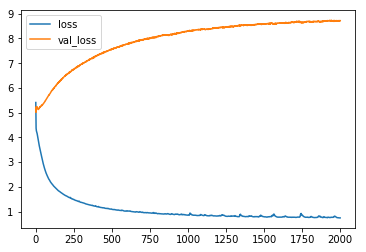

In [31]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

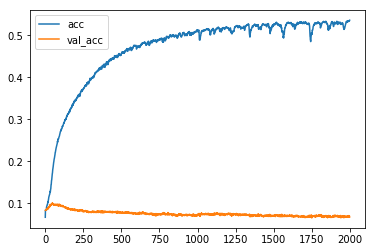

In [32]:
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

# Using our language model to generate sentences

## Create sampling model

In [34]:
# we'll only input one word at a time
input2 = Input(shape=(1,))
x = embedding_layer(input2)
# now we need states to feed back in
x, h, c = lstm(x, initial_state=[initial_h, initial_c])
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])


### Reverse word2idx dictionary to get back words during prediction

In [35]:
idx2word = {v:k for k, v in word2idx.items()}

In [49]:
def sample_line():
    # initial inputs
    # 1x1 array SOS token
    np_input = np.array([[ word2idx['<sos>'] ]])
    
    h = np.zeros((1, LATENT_DIM))
    c = np.zeros((1, LATENT_DIM))

    # so we know when to quit
    eos = word2idx['<eos>']

    # store the output here
    output_sentence = []

    for _ in range(max_sequence_length):
        o, h, c = sampling_model.predict([np_input, h, c])

        #print("o.shape:", o.shape, o[0,0,:10])
        
        probs = o[0,0]
        #idx = np.argmax(probs)
        # sometimes can be high probability for index 0
        # on more iterations should be gone
        if np.argmax(probs) == 0:
            print("wtf")
        probs[0] = 0
        probs /= probs.sum()
        
        idx = np.random.choice(len(probs), p=probs)
        if idx == eos:
            break

        # accumulate output
        output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

        # make the next input into model
        np_input[0,0] = idx

    return ' '.join(output_sentence)

In [50]:
for _ in range(4):
    print(sample_line())

but old so any time being.
the faintest restless rustling ran all through them.
of the west was adding frost to snow of make-believe,
of a beaded fur. as if.


In [58]:
sampling_model.save('./data/models/sampling_model.model')

/home/ineersa/PycharmProjects/iris/venv/lib/python3.7/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_2:0' shape=(?, 25) dtype=float32>, <tf.Tensor 'input_3:0' shape=(?, 25) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [57]:
model.save('./data/models/frost.model')

In [59]:
from keras.models import load_model
model2 = load_model('./data/models/frost.model')

In [70]:
from keras.models import load_model
sampling_model2 = load_model('./data/models/sampling_model.model')

/home/ineersa/PycharmProjects/iris/venv/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [71]:
def sample_line():
    # initial inputs
    # 1x1 array SOS token
    np_input = np.array([[ word2idx['<sos>'] ]])
    
    h = np.zeros((1, LATENT_DIM))
    c = np.zeros((1, LATENT_DIM))

    # so we know when to quit
    eos = word2idx['<eos>']

    # store the output here
    output_sentence = []

    for _ in range(max_sequence_length):
        o, h, c = sampling_model2.predict([np_input, h, c])

        #print("o.shape:", o.shape, o[0,0,:10])
        
        probs = o[0,0]
        #idx = np.argmax(probs)
        # sometimes can be high probability for index 0
        # on more iterations should be gone
        if np.argmax(probs) == 0:
            print("wtf")
        probs[0] = 0
        probs /= probs.sum()
        
        idx = np.random.choice(len(probs), p=probs)
        if idx == eos:
            break

        # accumulate output
        output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

        # make the next input into model
        np_input[0,0] = idx

    return ' '.join(output_sentence)

In [94]:
print(sample_line())

me? heard to say that we'd heard before the stone baptismal font.
